# Techniques to Improve the Neural Network

Things to try: adding channels, data augmentation

`data.py` file

In [1]:
import numpy as np
import pydicom as dicom
import random
import os
from glob import glob
import scipy.ndimage
import re
import sys
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def load_scan(path):
    #slices = [dicom.read_file((path + '/' + s) for s in os.listdir(path))]
    slices = []
    for file in glob(path + '/*.DCM'):
        slices.append(dicom.read_file(file))
    slices.sort(key = lambda x: int(x.InstanceNumber)) # sort by slice number
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def show_dcm_info(dataset, path):
    print("Filename.........:", path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    if 'ViewPosition' in dataset:
        print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=4, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    ind = start_with
    for i in range(rows):
        for j in range(cols):
            ax[i,j].set_title('slice %d' % (ind+1))
            ax[i,j].imshow(stack[ind],cmap='gray')
            ax[i,j].axis('off')
            ind = ind + show_every
    plt.show()

def get_data(TRAIN_PATH,TEST_PATH,IMG_WIDTH,IMG_HEIGHT,NUM_SLICES,IMG_CHANNELS):
    # Get train and test IDs
    train_ids = next(os.walk(TRAIN_PATH+'imgs/'))[2]
    test_ids = next(os.walk(TEST_PATH+'imgs/'))[2]

    # Get and resize train images and masks
    #print('Getting train images and masks ... ')
    X_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        i = 0
        path = TRAIN_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TRAIN_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_train[n*NUM_SLICES + i] = img[i]
            y_train[n*NUM_SLICES + i] = mask[i]
            i+=1

    # Get and resize test images
    #print('Getting test images and masks ... ')
    X_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sizes_test = []
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        i = 0
        path = TEST_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        sizes_test.append([img.shape[0], img.shape[1]])
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TEST_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_test[n*NUM_SLICES + i] = img[i]
            y_test[n*NUM_SLICES + i] = mask[i]
            i+=1
    print('Done!')

    return (X_train, X_test, y_train, y_test)

## Add channels

In [9]:
train_ids = ['E3420','E4634','E5125','E5093','E3654','E3579','E3625','E2604',
             'E3994','E5145','E4746','E3015','E4809','E3822','E4492','E2914',
             'E3623','E4407','E2610','E3670','E4849','E4024','E5119','E3962',
             'E3049','E3110','E4635','E4689','E4619','E1900','E3815','E3394',
             'E2964','E3572']
test_ids = ['E2692','E2907','E4451','E3544','E5021','E3377','E3429','E3622','E3027']

for imgtype in ["02","00"]:
    for n in train_ids:
        PATIENT_ID = n
        #IMG_TYPE = "01" #for water, "02" for fat, "10" for fat frac, "00" for r2*
        IMG_TYPE = imgtype
        DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/*"+IMG_TYPE+"/"
        OUTPUT_PATH = "./train/"
        print("Processing patient ", n)
        patient = load_scan(DATA_PATH)
        imgs = get_pixels(patient)
        if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
            print("Patient %s doesn't have 20 slices" % n)
        else:
            np.save(OUTPUT_PATH + IMG_TYPE + "/fullimages_%s.npy" % (PATIENT_ID), imgs)

for imgtype in ["02","00"]:
    for n in test_ids:
        PATIENT_ID = n
        #IMG_TYPE = "01" #for water, "02" for fat, "10" for fat frac, "00" for r2*
        IMG_TYPE = imgtype
        DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/*"+IMG_TYPE+"/"
        OUTPUT_PATH = "./test/"
        print("Processing patient ", n)
        patient = load_scan(DATA_PATH)
        imgs = get_pixels(patient)
        if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
            print("Patient %s doesn't have 20 slices" % n)
        else:
            np.save(OUTPUT_PATH + IMG_TYPE + "/fullimages_%s.npy" % (PATIENT_ID), imgs)


Processing patient  E3420
Processing patient  E4634
Processing patient  E5125
Processing patient  E5093
Processing patient  E3654
Processing patient  E3579
Processing patient  E3625
Processing patient  E2604
Processing patient  E3994
Processing patient  E5145
Processing patient  E4746
Processing patient  E3015
Processing patient  E4809
Processing patient  E3822
Processing patient  E4492
Processing patient  E2914
Processing patient  E3623
Processing patient  E4407
Processing patient  E2610
Processing patient  E3670
Processing patient  E4849
Processing patient  E4024
Processing patient  E5119
Processing patient  E3962
Processing patient  E3049
Processing patient  E3110
Patient E3110 doesn't have 20 slices
Processing patient  E4635
Processing patient  E4689
Processing patient  E4619
Processing patient  E1900
Processing patient  E3815
Processing patient  E3394
Processing patient  E2964
Processing patient  E3572
Processing patient  E3420
Processing patient  E4634
Processing patient  E5125
P

Fat fraction folder names are either 9, 10 or 11... how to factor this in... hardcoding for the one patient that has a folder named 9 and the one with a folder named 8

In [16]:
for n in train_ids:
    PATIENT_ID = n
    if PATIENT_ID == "E4407":
        DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/?/"
    else:
        DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/1?/"
    OUTPUT_PATH = "./train/"
    print("Processing patient ", n)
    patient = load_scan(DATA_PATH)
    imgs = get_pixels(patient)
    if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
        print("Patient %s doesn't have 20 slices" % n)
    else:
        np.save(OUTPUT_PATH + "ff" + "/fullimages_%s.npy" % (PATIENT_ID), imgs)

Processing patient  E3420
Processing patient  E4634
Processing patient  E5125
Processing patient  E5093
Processing patient  E3654
Processing patient  E3579
Processing patient  E3625
Processing patient  E2604
Processing patient  E3994
Processing patient  E5145
Processing patient  E4746
Processing patient  E3015
Processing patient  E4809
Processing patient  E3822
Processing patient  E4492
Processing patient  E2914
Processing patient  E3623
Processing patient  E4407
Processing patient  E2610
Processing patient  E3670
Processing patient  E4849
Processing patient  E4024
Processing patient  E5119
Processing patient  E3962
Processing patient  E3049
Processing patient  E3110
Patient E3110 doesn't have 20 slices
Processing patient  E4635
Processing patient  E4689
Processing patient  E4619
Processing patient  E1900
Processing patient  E3815
Processing patient  E3394
Processing patient  E2964
Processing patient  E3572


In [18]:
for n in test_ids:
    PATIENT_ID = n
    if PATIENT_ID == "E2692":
        DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/?/"
    else:
        DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/1?/"
    OUTPUT_PATH = "./test/"
    print("Processing patient ", n)
    patient = load_scan(DATA_PATH)
    imgs = get_pixels(patient)
    if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
        print("Patient %s doesn't have 20 slices" % n)
    else:
        np.save(OUTPUT_PATH + "ff" + "/fullimages_%s.npy" % (PATIENT_ID), imgs)

Processing patient  E2692
Processing patient  E2907
Processing patient  E4451
Processing patient  E3544
Processing patient  E5021
Processing patient  E3377
Processing patient  E3429
Processing patient  E3622
Processing patient  E3027
Patient E3027 doesn't have 20 slices


Rename the other folder names to be more descriptive

In [19]:
os.rename("train/02","train/fat")
os.rename("train/00","train/r2")
os.rename("test/02","test/fat")
os.rename("test/00","test/r2")

Move folders around for easy loading - for reference, 0 = water, 1 = fat, 2 = ff, 3 = R2*

In [23]:
os.rename("train/imgs/","train/0")
os.rename("train/fat","train/1")
os.rename("train/ff","train/2")
os.rename("train/r2","train/3")
os.rename("test/imgs/","test/0")
os.rename("test/fat","test/1")
os.rename("test/ff","test/2")
os.rename("test/r2","test/3")
os.mkdir("train/imgs")
os.mkdir("test/imgs")

In [24]:
import shutil

for ind in range(4):
    shutil.move("train/"+str(ind),"train/imgs")
    shutil.move("test/"+str(ind),"test/imgs")

### Include more channels in model
Let's see if we can do this with the already-defined unet model, but will need to redefine the `get_data` function

`model.py` file

In [20]:
from keras.models import Model, load_model, model_from_json
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# define metrics

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Build U-Net model
def unet(width, height, channels, pretrained_weights = None):
    inputs = Input((width, height, channels))
    s = Lambda(lambda x: x / 255) (inputs) 

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    model.summary()

    return model

Using TensorFlow backend.
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [34]:
def get_data(TRAIN_PATH,TEST_PATH,IMG_WIDTH,IMG_HEIGHT,NUM_SLICES,IMG_CHANNELS):
    # Get train and test IDs
    train_ids = next(os.walk(TRAIN_PATH+'imgs/0/'))[2]
    test_ids = next(os.walk(TEST_PATH+'imgs/0/'))[2]

    # Get and resize train images and masks
    #print('Getting train images and masks ... ')
    X_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        for ch in range(IMG_CHANNELS):
            i = 0
            path = TRAIN_PATH + 'imgs/' + str(ch) + '/' + id_
            img = np.load(path)[:,:,:]
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            maskpath = TRAIN_PATH + 'labels/' + id_
            mask_ = np.load(maskpath)[:,:,:,np.newaxis]
            mask = np.maximum(mask, mask_)
            for i in range(NUM_SLICES):
                X_train[n*NUM_SLICES + i,:,:,ch] = img[i]
                y_train[n*NUM_SLICES + i] = mask[i]
                i+=1

    # Get and resize test images
    #print('Getting test images and masks ... ')
    X_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sizes_test = []
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        for ch in range(IMG_CHANNELS):
            i = 0
            path = TEST_PATH + 'imgs/' + str(ch) + '/' + id_
            img = np.load(path)[:,:,:]
            sizes_test.append([img.shape[0], img.shape[1]])
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            maskpath = TEST_PATH + 'labels/' + id_
            mask_ = np.load(maskpath)[:,:,:,np.newaxis]
            mask = np.maximum(mask, mask_)
            for i in range(NUM_SLICES):
                X_test[n*NUM_SLICES + i,:,:,ch] = img[i]
                y_test[n*NUM_SLICES + i] = mask[i]
                i+=1
    print('Done!')

    return (X_train, X_test, y_train, y_test)

In [35]:
# Parameters
width = 256
height = 256
slices = 20
channels = 4
trainpath = './train/'
testpath = './test/'

(X_train, X_test, y_train, y_test) = get_data(trainpath, testpath, width, height, slices, channels)

100%|██████████| 8/8 [00:00<00:00, 39.32it/s]

Done!


In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(660, 256, 256, 4)
(160, 256, 256, 4)
(660, 256, 256, 1)
(160, 256, 256, 1)


In [40]:
if os.path.exists('./model-2.h5'):
    weights = './model-2.h5'
    model = unet(width, height, channels, weights)
else:
    model = unet(width, height, channels)

# Fit model
es = EarlyStopping(patience=5, verbose=1)
mc = ModelCheckpoint('model-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=16, epochs=50, 
                    callbacks=[es, mc])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 592         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                 

Model is improving over time - let's look at the training history and run for a longer time

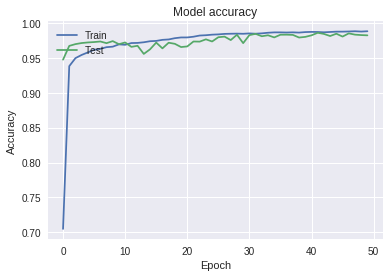

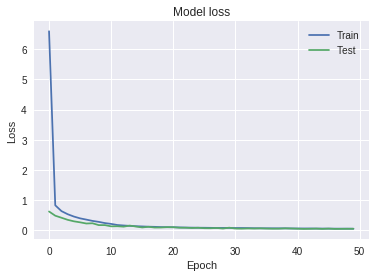

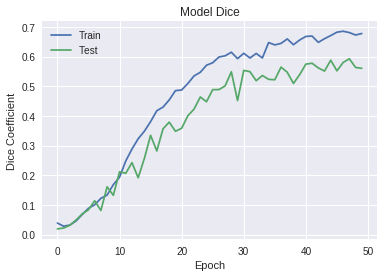

In [43]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation dice coefficients
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model Dice')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
es = EarlyStopping(patience=50, verbose=1)
mc = ModelCheckpoint('model-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=4, epochs=500, 
                    callbacks=[es, mc])

Train on 528 samples, validate on 132 samples
Epoch 1/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0660 - dice_coef: 0.5269 - accuracy: 0.9851 - val_loss: 0.0522 - val_dice_coef: 0.3388 - val_accuracy: 0.9835

Epoch 00001: val_loss improved from inf to 0.05225, saving model to model-2.h5
Epoch 2/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0600 - dice_coef: 0.5379 - accuracy: 0.9862 - val_loss: 0.0526 - val_dice_coef: 0.3477 - val_accuracy: 0.9810

Epoch 00002: val_loss did not improve from 0.05225
Epoch 3/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0526 - dice_coef: 0.5772 - accuracy: 0.9878 - val_loss: 0.0410 - val_dice_coef: 0.3365 - val_accuracy: 0.9882

Epoch 00003: val_loss improved from 0.05225 to 0.04102, saving model to model-2.h5
Epoch 4/500
528/528 [==============================] - 4s 8ms/step - loss: 0.0505 - dice_coef: 0.5637 - accuracy: 0.9879 - val_loss: 0.0409 - val_dice_coef: 0.3348 - val_accurac

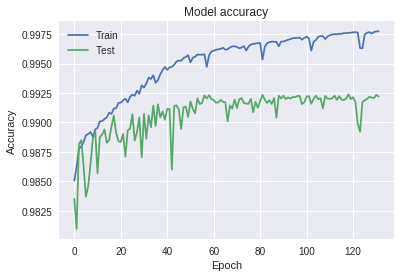

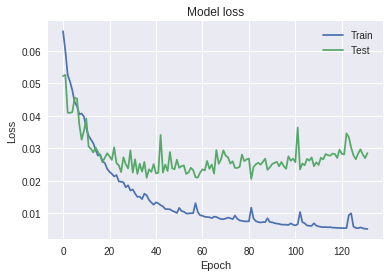

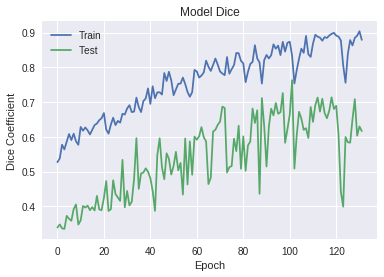

In [45]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation dice coefficients
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model Dice')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Is binary cross entropy a good loss function for this? Or should we try using the soft Dice coefficient (1-Dice) as a loss function for segmentation? However, Dice seems to jump around a lot

### Save the model

In [46]:
model_json = model.to_json()
with open("model-2.json", "w") as json_file:
    json_file.write(model_json)

### Evaluate the model

In [47]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[0].set_title('Full Scan')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[1].set_title('Ground Truth Vertebrae')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[2].set_title('Predicted Vertebrae')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title('Predicted Vertebrae binary')
    diceco = dice(y[ix].squeeze(),binary_preds[ix].squeeze())
    ax[3].annotate('Dice: '+str(round(diceco,4)),
                   xy=(0.7,0.05),
                   xycoords='axes fraction',
                   c='w',
                   fontsize='large',
                   fontweight='bold')
    

In [48]:
# Evaluate on validation set
model.evaluate(X_test, y_test, verbose=1)

160/160 [==============================] - 1s 5ms/step


[0.04904387965798378, 0.762322187423706, 0.9893458485603333]

In [49]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

160/160 [==============================] - 0s 2ms/step


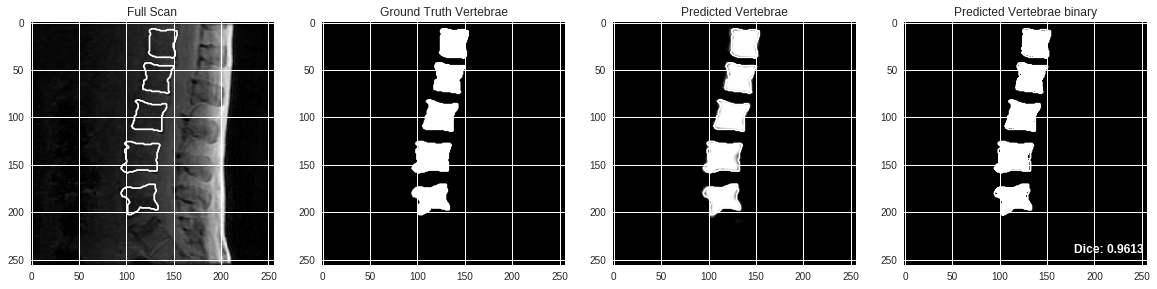

In [63]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t) #ix = 10
plt.savefig('training_preds.pdf', dpi=300)

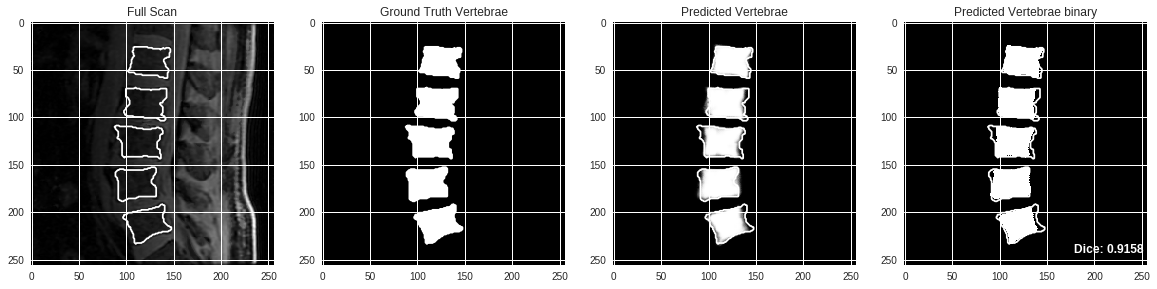

In [67]:
# Check if testing data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t) #ix = 10
plt.savefig('testing_preds.pdf', dpi=300)

Needs a bit more work

## Data augmentation

In [77]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [82]:
batch_size = 4

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    subset='training') # set as training data

validation_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    subset='validation') # set as validation data

es = EarlyStopping(patience=50, verbose=1)
mc = ModelCheckpoint('model-3.h5', verbose=1, monitor='val_dice_coef', mode='max', save_best_only=True)
results = model.fit_generator(train_generator,
                              verbose=1,
                              steps_per_epoch = int(round(0.8*len(X_train))) // batch_size,
                              validation_data = validation_generator,
                              validation_steps = int(round(0.2*len(X_train))) // batch_size,
                              epochs=500,
                              callbacks=[es, mc])

Epoch 1/500
132/132 [==============================] - 7s 56ms/step - loss: 0.0531 - dice_coef: 0.2206 - accuracy: 0.9765 - val_loss: 0.0421 - val_dice_coef: 0.2330 - val_accuracy: 0.9757

Epoch 00001: val_dice_coef improved from -inf to 0.23300, saving model to model-3.h5
Epoch 2/500
132/132 [==============================] - 7s 50ms/step - loss: 0.0530 - dice_coef: 0.2407 - accuracy: 0.9767 - val_loss: 0.0791 - val_dice_coef: 0.2151 - val_accuracy: 0.9756

Epoch 00002: val_dice_coef did not improve from 0.23300
Epoch 3/500
132/132 [==============================] - 7s 52ms/step - loss: 0.0530 - dice_coef: 0.2314 - accuracy: 0.9766 - val_loss: 0.1354 - val_dice_coef: 0.2277 - val_accuracy: 0.9755

Epoch 00003: val_dice_coef did not improve from 0.23300
Epoch 4/500
132/132 [==============================] - 7s 51ms/step - loss: 0.0539 - dice_coef: 0.2352 - accuracy: 0.9766 - val_loss: 0.0867 - val_dice_coef: 0.2152 - val_accuracy: 0.9756

Epoch 00004: val_dice_coef did not improve from

In [85]:
# Evaluate on validation set
test_generator = test_datagen.flow(
    X_test, y_test)
model.evaluate_generator(test_generator, verbose=1)

5/5 [==============================] - 0s 71ms/step


[0.07554766535758972, 0.28466689586639404, 0.9735926389694214]

In [86]:
# Predict on train and test
preds_train = model.predict_generator(train_generator, verbose=1)
preds_test = model.predict_generator(test_generator, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 1s 127ms/step


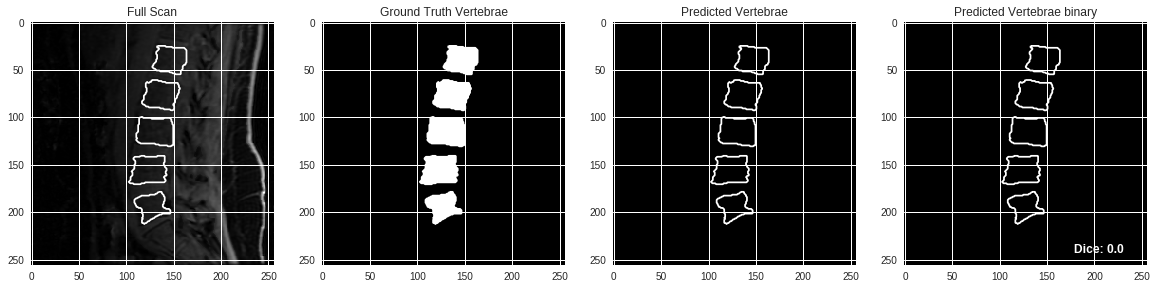

In [99]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t) #ix = 10
plt.savefig('training_preds.pdf', dpi=300)

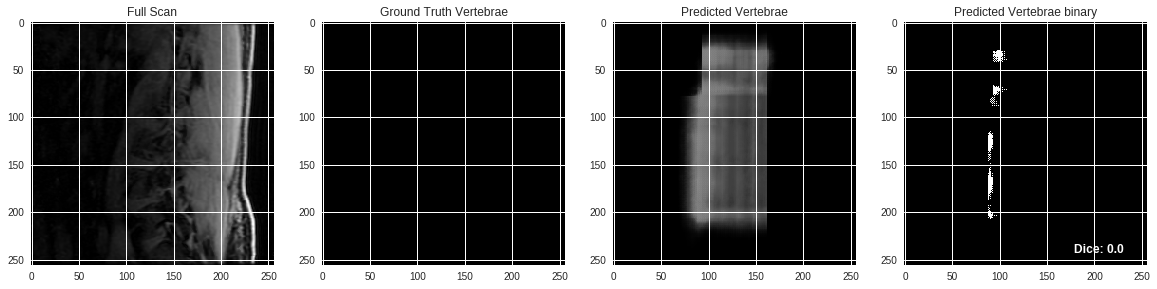

In [100]:
# Check if testing data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t) #ix = 10
plt.savefig('testing_preds.pdf', dpi=300)

Bleh doesn't look like data augmentation is helping much at all

## Dice as loss

In [117]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [118]:
# Build U-Net model
def unet(width, height, channels, pretrained_weights = None):
    inputs = Input((width, height, channels))
    s = Lambda(lambda x: x / 255) (inputs) 

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=[dice_coef,'accuracy'])
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    model.summary()

    return model

In [119]:
# Parameters
width = 256
height = 256
slices = 20
channels = 4

params = {'IMG_WIDTH' : width,
          'IMG_HEIGHT' : height,
          'NUM_SLICES' : slices,
          'IMG_CHANNELS' : channels,
          'TRAIN_PATH' : './train/',
          'TEST_PATH' : './test/'}

(X_train, X_test, y_train, y_test) = get_data(**params)

100%|██████████| 8/8 [00:00<00:00, 46.62it/s]

Done!


In [120]:
if os.path.exists('./model-3.h5'):
    weights = './model-3.h5'
    model = unet(width, height, channels, weights)
else:
    model = unet(width, height, channels)

es = EarlyStopping(patience=50, verbose=1)
mc = ModelCheckpoint('model-3.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=4, epochs=500, 
                    callbacks=[es, mc])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 4)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 16) 592         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 256, 256, 16) 0           conv2d_58[0][0]                  
____________________________________________________________________________________________

## Jaccard as loss
Supposedly should prevent vanishing gradients that might occur with Dice loss

In [122]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [123]:
# Build U-Net model
def unet(width, height, channels, pretrained_weights = None):
    inputs = Input((width, height, channels))
    s = Lambda(lambda x: x / 255) (inputs) 

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-4), loss=jaccard_distance_loss, metrics=[dice_coef,'accuracy'])
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    model.summary()

    return model

In [124]:
# Parameters
width = 256
height = 256
slices = 20
channels = 4

params = {'IMG_WIDTH' : width,
          'IMG_HEIGHT' : height,
          'NUM_SLICES' : slices,
          'IMG_CHANNELS' : channels,
          'TRAIN_PATH' : './train/',
          'TEST_PATH' : './test/'}

(X_train, X_test, y_train, y_test) = get_data(**params)

100%|██████████| 8/8 [00:00<00:00, 46.11it/s]

Done!


In [125]:
if os.path.exists('./model-3.h5'):
    weights = './model-3.h5'
    model = unet(width, height, channels, weights)
else:
    model = unet(width, height, channels)

es = EarlyStopping(patience=50, verbose=1)
mc = ModelCheckpoint('model-3.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=4, epochs=500, 
                    callbacks=[es, mc])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 4)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 592         lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 256, 256, 16) 0           conv2d_77[0][0]                  
____________________________________________________________________________________________

In [126]:
# Evaluate on validation set
model.evaluate(X_test, y_test, verbose=1)

160/160 [==============================] - 0s 3ms/step


[0.024845950677990912, 1.9951568901888095e-05, 0.9749056100845337]

In [127]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

160/160 [==============================] - 0s 2ms/step


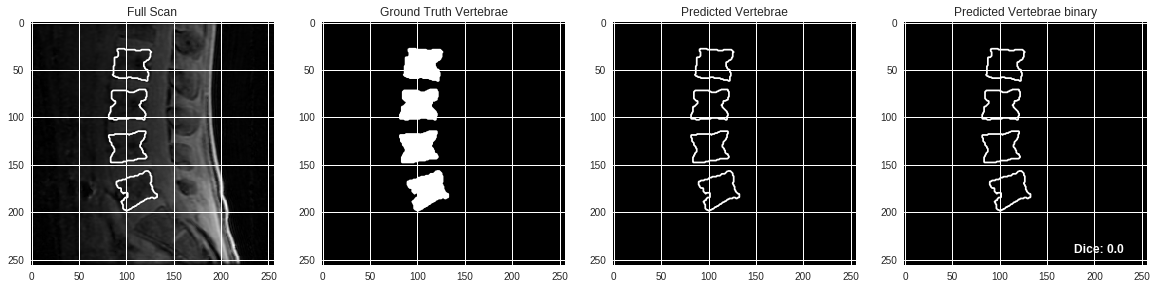

In [150]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix = 10)
plt.savefig('training_preds.pdf', dpi=300)

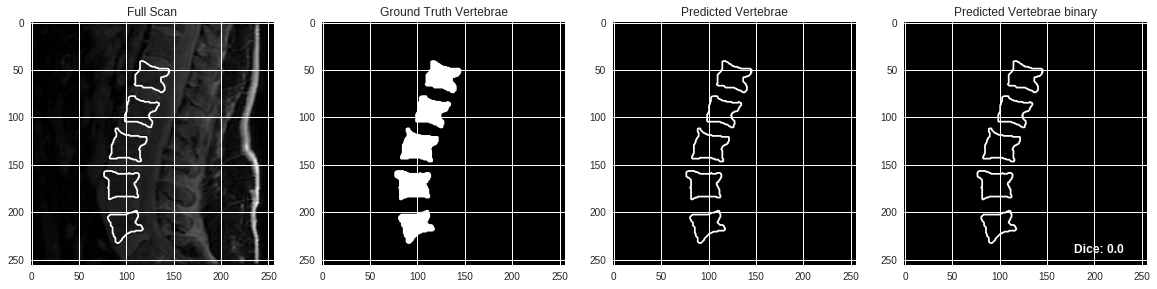

In [149]:
# Check if testing data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix = 10)
plt.savefig('testing_preds.pdf', dpi=300)

OK so now it's not even predicting a single thing... back to the drawing board